In [43]:
# Basic Libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time 
import random
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set() # set the default Seaborn style for graphics

AMD_data = pd.read_csv('AMD_cleaned.csv')
AMD_data = AMD_data.drop(columns = ['Unnamed: 0'])
Nvidia_data = pd.read_csv('Nvidia_cleaned.csv')
Nvidia_data = Nvidia_data.drop(columns = ['Unnamed: 0'])

In [44]:
frames = [AMD_data, Nvidia_data]
combined_data = pd.concat(frames)
combined_data = combined_data.dropna(subset=['Max. TDP (W)'])
combined_data = combined_data.drop(columns = ['Arbitrary Gen', 'Shading Units'])
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496 entries, 0 to 278
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Manufacturer             496 non-null    object 
 1   Foundry                  496 non-null    object 
 2   Architecture             496 non-null    object 
 3   Gen Year                 496 non-null    int64  
 4   FP32 (float) in GFLOPS   496 non-null    float64
 5   Memory Size (MB)         496 non-null    float64
 6   Memory Type              496 non-null    object 
 7   Bus Width (bits)         496 non-null    int64  
 8   GPU clock (MHz)          496 non-null    float64
 9   Memory clock (MHz)       496 non-null    float64
 10  Process Size (nm)        496 non-null    float64
 11  Transistors (millions)   496 non-null    float64
 12  Density (M/mm²)          496 non-null    float64
 13  Die Size (mm²)           496 non-null    float64
 14  Max. TDP (W)             496 no

In [45]:
# Identifying categorical variables for encoding
categorical_cols = combined_data.select_dtypes(include=['object']).columns

# Displaying unique values in each categorical column to assess need for encoding
{col: combined_data[col].nunique() for col in categorical_cols}

{'Manufacturer': 2, 'Foundry': 4, 'Architecture': 24, 'Memory Type': 10}

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Selecting features and target variables
X = combined_data[['Manufacturer', 'Foundry', 'Architecture', 'Memory Type', 'Memory Size (MB)', 'Bus Width (bits)', 
          'GPU clock (MHz)', 'Memory clock (MHz)', 'Process Size (nm)', 'Transistors (millions)', 
          'Density (M/mm²)', 'Die Size (mm²)', 'Max. TDP (W)', 'L2 Cache (KB)']]
y = combined_data[['FP32 (float) in GFLOPS', 'Pixel Rate (GPixel/s)', 'Texture Rate (GTexel/s)']]

# Defining numerical and categorical columns
numerical_cols = ['Memory Size (MB)', 'Bus Width (bits)', 'GPU clock (MHz)', 'Memory clock (MHz)', 
                  'Process Size (nm)', 'Transistors (millions)', 'Density (M/mm²)', 'Die Size (mm²)', 
                  'Max. TDP (W)', 'L2 Cache (KB)']
categorical_cols = ['Manufacturer', 'Foundry', 'Architecture', 'Memory Type']

# Creating a transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Showing the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((396, 14), (100, 14), (396, 3), (100, 3))

In [47]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

# Creating the XGBoost model
xgb_model = XGBRegressor(n_estimators=50, max_depth=3, objective='reg:squarederror')

# Setting up the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', MultiOutputRegressor(xgb_model))])

# Training the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Memory Size (MB)',
                                                   'Bus Width (bits)',
                                                   'GPU clock (MHz)',
                                                   'Memory clock (MHz)',
                                                   'Process Size (nm)',
                                                   'Transistors (millions)',
                                                   'Density (M/mm²)',
                                                   'Die Size (mm²)',
                                                   'Max. TDP (W)',
                                                   'L2 Cache (KB)']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Manufacturer', 'Foundry',
                                                   'Architecture',
                                                   'M...
                                                             gpu_id=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=50,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...)))])

In [48]:
from sklearn.metrics import mean_squared_error, r2_score
# Predicting on training and testing data
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Calculating RMSE and R² for training and testing sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

(train_rmse, train_r2, test_rmse, test_r2)

(274.6940020877659, 0.9982543251524372, 885.2853521975355, 0.962202770101997)

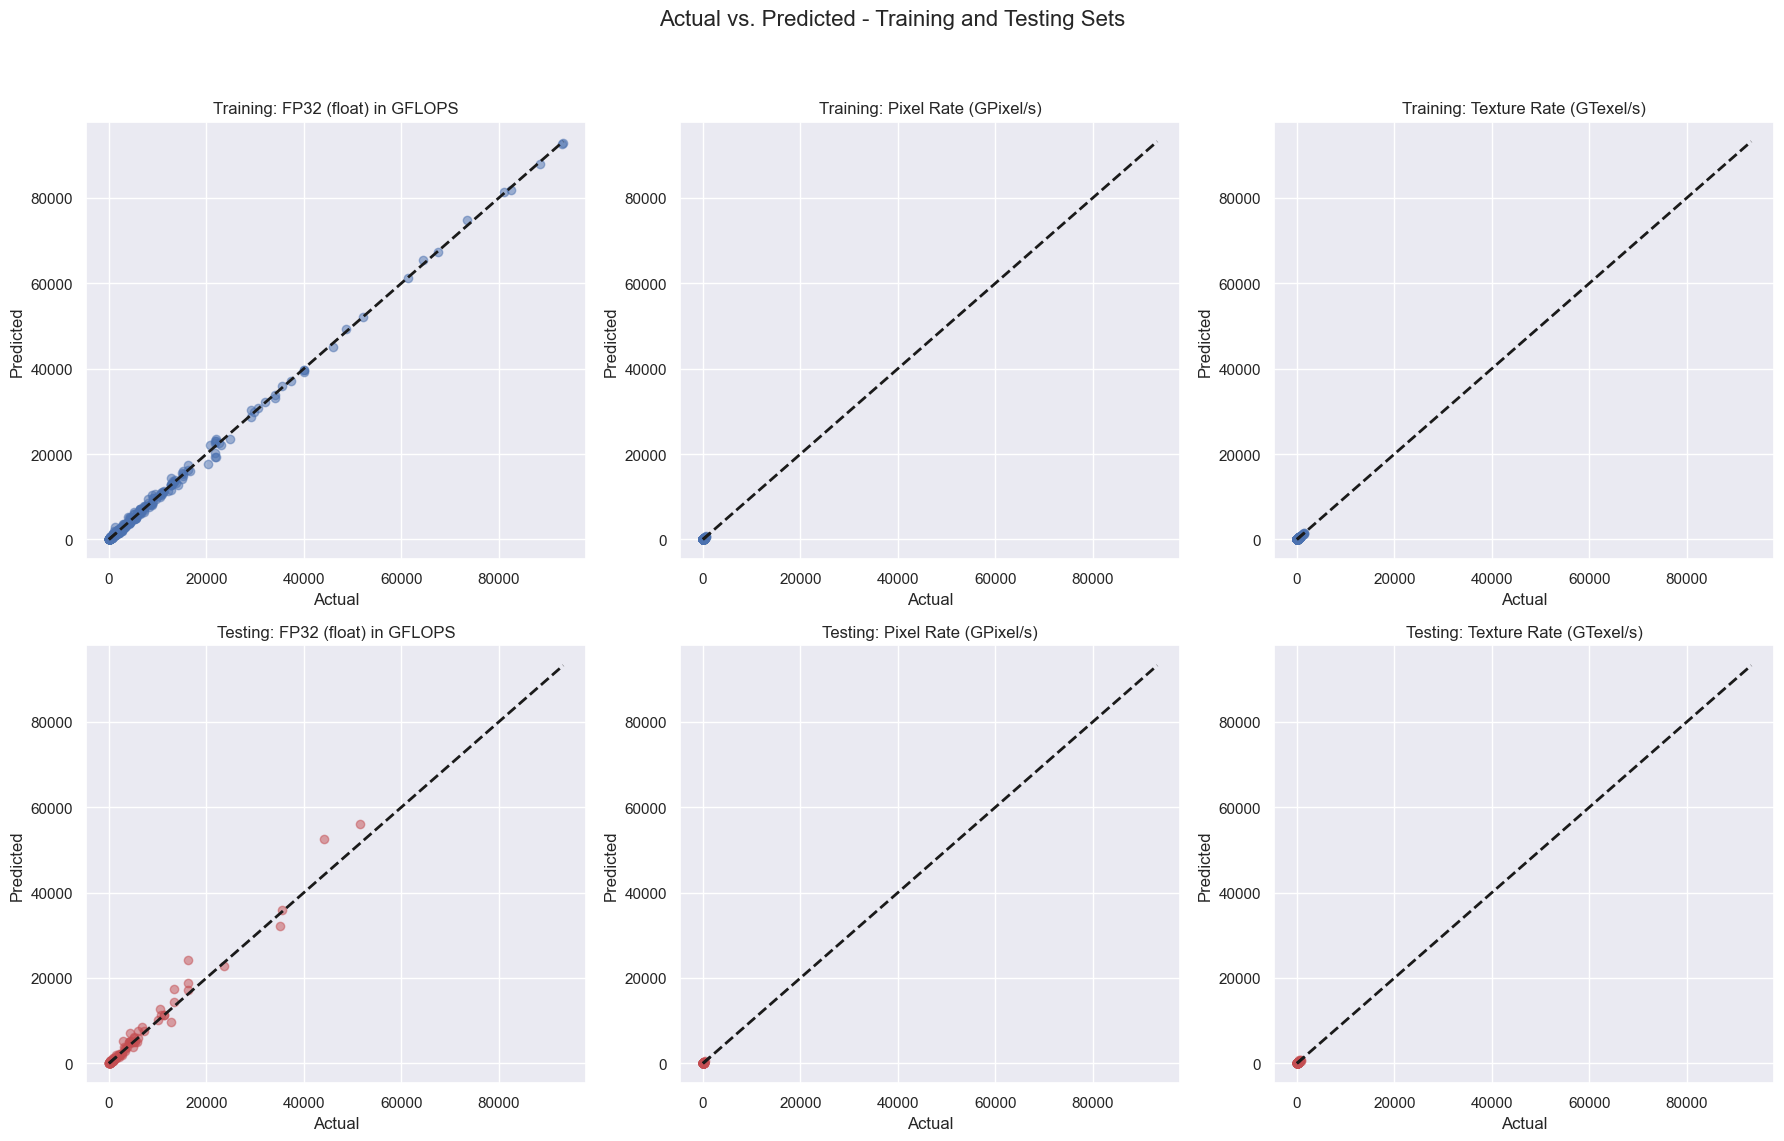

In [49]:
import matplotlib.pyplot as plt
# Setting up the plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Actual vs. Predicted - Training and Testing Sets', fontsize=16)

# Titles for subplots
titles = ['FP32 (float) in GFLOPS', 'Pixel Rate (GPixel/s)', 'Texture Rate (GTexel/s)']

# Plotting training data
for i in range(3):
    axes[0, i].scatter(y_train.iloc[:, i], y_train_pred[:, i], alpha=0.5)
    axes[0, i].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    axes[0, i].set_title(f'Training: {titles[i]}')
    axes[0, i].set_xlabel('Actual')
    axes[0, i].set_ylabel('Predicted')

# Plotting testing data
for i in range(3):
    axes[1, i].scatter(y_test.iloc[:, i], y_test_pred[:, i], alpha=0.5, color='r')
    axes[1, i].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    axes[1, i].set_title(f'Testing: {titles[i]}')
    axes[1, i].set_xlabel('Actual')
    axes[1, i].set_ylabel('Predicted')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [50]:
# Extract feature importances from each regressor and average them
importances = np.array([est.feature_importances_ for est in pipeline.named_steps['regressor'].estimators_])
mean_importances = np.mean(importances, axis=0)

# Getting feature names after preprocessing (handling categorical variables)
feature_names = (pipeline.named_steps['preprocessor'].transformers_[1][1]
                 .get_feature_names_out(categorical_cols))
all_feature_names = np.concatenate([numerical_cols, feature_names])

# Creating a DataFrame for easier visualization
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': mean_importances
}).sort_values(by='Importance', ascending=False)

importance_df.head(10)

,Feature,Importance
5,Transistors (millions),0.692025
0,Memory Size (MB),0.199410
13,Foundry_Samsung,0.013375
4,Process Size (nm),0.012665
2,GPU clock (MHz),0.012599
3,Memory clock (MHz),0.012014
6,Density (M/mm²),0.010523
10,Manufacturer_AMD,0.006505
46,Memory Type_GDDR6X,0.005732
23,Architecture_GCN 4.0,0.005142


### Comment:

Here, we used the Pixel Rate and Texture Rate together with FP32 (float) as a measure of performance. Using Multi Output Regression, we are able to have multiple response variables. We also make use of XGBoost as seen from the previous Notebook as it was shown to be the most balance.

Unsurprisingly, Transistors and Memory Size are the most important features, consistent with the previous 3 models.

Though most surprising is that Samsung is decided to be the best in making GPUs in terms of performance.

### Why Multi Output Regressor?

FP32 is the industry standard for measuring performance so single output model is sufficient but we were curious in what would happen if we take into account Pixel Rate and Texture Rate of the GPUs as a part of the measure of performance.